# Análise Exploratória para Ofertas Relâmpago

### Instale dependências necessarias via:
```
pip instal requirements.txt
```

In [2]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('ggplot')

/home/robsonortz/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/robsonortz/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [22]:
def secounds_difference(begin_date, end_date):
    '''
    Function that calculates the current period of offer, in hours.
    '''
    begin = datetime.strptime(begin_date, '%Y-%m-%d %H:%M:%S%z')
    end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S%z')
    
    return (end - begin).total_seconds()

### Leitura e Validação dos Dados

Notamos que algumas colunas contêm valores nulos. Algumas delas serão desconsideradas pelo montante massivo de dados nulos: SHIPPING_PAYMENT_TYPE (uma vez que 'none' parece não descrever alguma outra forma pagamento pela entrega), ORIGIN.

A colunas INVOLVED_STOCK, REMAINING_STOCK_AFTER_END e SOLD_QUANTITY foram imputadas via subtração e verificação lógica como seguem: 

In [23]:
data = pd.read_csv("data/ofertas_relampago.csv")
data.loc[(data['INVOLVED_STOCK'] == data['REMAINING_STOCK_AFTER_END']), 'SOLD_QUANTITY'] = 0
data.loc[(data['INVOLVED_STOCK'] == data['REMAINING_STOCK_AFTER_END']), 'SOLD_AMOUNT'] = 0
data['SOLD_QUANTITY'] = data['INVOLVED_STOCK'] - data['REMAINING_STOCK_AFTER_END']
data.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,0.00,0,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


No entanto, para coluna SOLD_QUANTITY utilizamos a estratégia de imputação pela mediana estratificada por DOM_DOMAIN_AGG1:
* a média promove uma estratégia rápida e fácil para análises exploratórias, além de serem mais adequadas quando a variável apresenta sobredispersão (quando a variabilidade dos dados é muito mais alta em relação a sua média);
* as colunas VERTICAL e DOMAIN_ID não foram utilizadas para estratificação, umas vez que elas ofereciam agrupamentos muito granulares.

A seguir, apresentamos as tabelas contendo a sumarização e a quandidade de valores nulos de SOLD_QUANTITY por DOM_DOMAIN_AGG1.

In [5]:
null_count = data[['SOLD_AMOUNT']].isnull().groupby(data['DOM_DOMAIN_AGG1']).sum().reset_index()
count_domain_agg1 = data[['SOLD_AMOUNT']].groupby(data['DOM_DOMAIN_AGG1']).count().reset_index()
count_domain_agg1 = count_domain_agg1[null_count['SOLD_AMOUNT']!=0]
null_count = null_count[null_count['SOLD_AMOUNT']!=0]

null_count['SOLD_AMOUNT_RATE'] = null_count['SOLD_AMOUNT'].div(count_domain_agg1['SOLD_AMOUNT'], level=1, fill_value=0)
null_count

,DOM_DOMAIN_AGG1,SOLD_AMOUNT,SOLD_AMOUNT_RATE
3,APPAREL,1,0.000259
5,AUTOPARTS,5,0.002957
6,BABY,37,0.048429
8,BEAUTY EQUIPMENT,3,0.002737
10,CLEANING,1,0.002786
11,COMPUTERS,199,0.055727
13,ELECTRONICS,159,0.055614
16,HOME&DECOR,15,0.002230
17,INDUSTRY,31,0.026541
18,MOBILE,50,0.027917


In [6]:
null_count = data[['SOLD_AMOUNT', 'SOLD_QUANTITY']].isnull().groupby(data['DOM_DOMAIN_AGG1']).sum().reset_index()
summary_data = data.groupby(data['DOM_DOMAIN_AGG1']).agg(
    SOLD_AMOUNT_MEDIAN=('SOLD_AMOUNT', np.median),
    SOLD_AMOUNT_MEAN=('SOLD_AMOUNT', np.mean),
    SOLD_AMOUNT_SD=('SOLD_AMOUNT', np.std)
).reset_index()
summary_data[null_count['SOLD_AMOUNT']!=0]

,DOM_DOMAIN_AGG1,SOLD_AMOUNT_MEDIAN,SOLD_AMOUNT_MEAN,SOLD_AMOUNT_SD
3,APPAREL,1.800,9.461422,32.099048
5,AUTOPARTS,2.360,8.786653,16.412567
6,BABY,0.000,5.818691,17.745722
8,BEAUTY EQUIPMENT,9.585,81.011515,249.413908
10,CLEANING,0.000,9.928663,19.731622
11,COMPUTERS,3.830,23.488692,88.094791
13,ELECTRONICS,0.000,41.872536,171.636586
16,HOME&DECOR,0.960,13.006078,34.164458
17,INDUSTRY,0.000,22.113750,118.735873
18,MOBILE,3.820,88.290424,336.817557


In [7]:
for _, row in summary_data.iterrows():
    data['SOLD_AMOUNT'] = [row[1] if math.isnan(data['SOLD_AMOUNT'][i]) and data['DOM_DOMAIN_AGG1'][i]==row[0] else data['SOLD_AMOUNT'][i] for i in range(len(data['SOLD_AMOUNT']))]

### Análise e _insights_  

Selecionamos as variáveis que usaremos para análise e adicionamos novas colunas:

In [8]:
df = data[['OFFER_START_DATE','INVOLVED_STOCK', 'REMAINING_STOCK_AFTER_END', 'SOLD_AMOUNT', 'SOLD_QUANTITY', 'DOM_DOMAIN_AGG1']]
df['HOUR_DIFF'] = [secounds_difference(d1,d2)/3600 for d1,d2 in zip(data['OFFER_START_DTTM'],data['OFFER_FINISH_DTTM'])]
df['HAS_STOCK_PROBLEM'] = [data['REMAINING_STOCK_AFTER_END']<0][0].values

/tmp/ipykernel_1112026/646160615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HOUR_DIFF'] = [secounds_difference(d1,d2)/3600 for d1,d2 in zip(data['OFFER_START_DTTM'],data['OFFER_FINISH_DTTM'])]
/tmp/ipykernel_1112026/646160615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HAS_STOCK_PROBLEM'] = [data['REMAINING_STOCK_AFTER_END']<0][0].values


Durante o processo de investigação, acabamos por focar na análise de tempo de validade da oferta (HOUR_DIFF), em horas, por ser a variável que mais trouxe informação a análise. 

Inicialmente focamos nos DOM_DOMAIN_AGG1 (que trataremos a partir de agora como departamento) cujas as ofertas tenham comprometido as vendas devido a sua disponibilidade (isto é, vendeu-se mais do que havia disponível).

In [9]:
dep_problem_stock_list = df[df['HAS_STOCK_PROBLEM']]['DOM_DOMAIN_AGG1'].unique()
dep_problem_stock = df[df['DOM_DOMAIN_AGG1'].isin(dep_problem_stock_list)].reset_index(drop=True)
dep_problem_stock.head()

,OFFER_START_DATE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,DOM_DOMAIN_AGG1,HOUR_DIFF,HAS_STOCK_PROBLEM
0,2021-06-22,4,-2,4.72,6,PETS FOOD,7.045278,True
1,2021-06-22,5,5,0.00,0,PET PRODUCTS,6.000556,False
2,2021-06-22,15,12,10.73,3,COMPUTERS,6.000278,False
3,2021-06-22,15,13,7.03,2,COMPUTERS,6.603333,False
4,2021-06-22,15,0,39.65,15,COMPUTERS,2.803333,False


Verificamos a quantidade de ofertas comprometidas em cada departamento e filtramos aqueles departamentos que possuia ao menos 10 ofertas com estoque negativado, após o período de vigência. O filtro foi motivado na tentativa de obter algum limitante de controle de tempo para as ofertas dentro de cada departamento. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'PETS FOOD'),
  Text(1, 0, 'PET PRODUCTS'),
  Text(2, 0, 'COMPUTERS'),
  Text(3, 0, 'ELECTRONICS'),
  Text(4, 0, 'APPAREL'),
  Text(5, 0, 'PARTY'),
  Text(6, 0, 'TOYS AND GAMES'),
  Text(7, 0, 'PERSONAL CARE'),
  Text(8, 0, 'INDUSTRY'),
  Text(9, 0, 'TOOLS AND CONSTRUCTION'),
  Text(10, 0, 'HOME&DECOR'),
  Text(11, 0, 'SPORTS'),
  Text(12, 0, 'AUTOPARTS'),
  Text(13, 0, 'DRINKS'),
  Text(14, 0, 'FOOTWEAR'),
  Text(15, 0, 'BEAUTY EQUIPMENT'),
  Text(16, 0, 'MOBILE'),
  Text(17, 0, 'APPAREL ACCESORIES'),
  Text(18, 0, 'FOODS'),
  Text(19, 0, 'PHARMACEUTICS'),
  Text(20, 0, 'STATIONARY'),
  Text(21, 0, 'BABY'),
  Text(22, 0, 'PERSONAL HYGIENE'),
  Text(23, 0, 'OTHER'),
  Text(24, 0, 'VEHICULAR MULTIMEDIA'),
  Text(25, 0, 'SECURITY'),
  Text(26, 0, 'MOTOPARTS'),
  Text(27, 0, 'CLEANING'),
  Text(28, 0, 'ACC TOOLS'),
  Text(29, 0, 'BATTERIES'

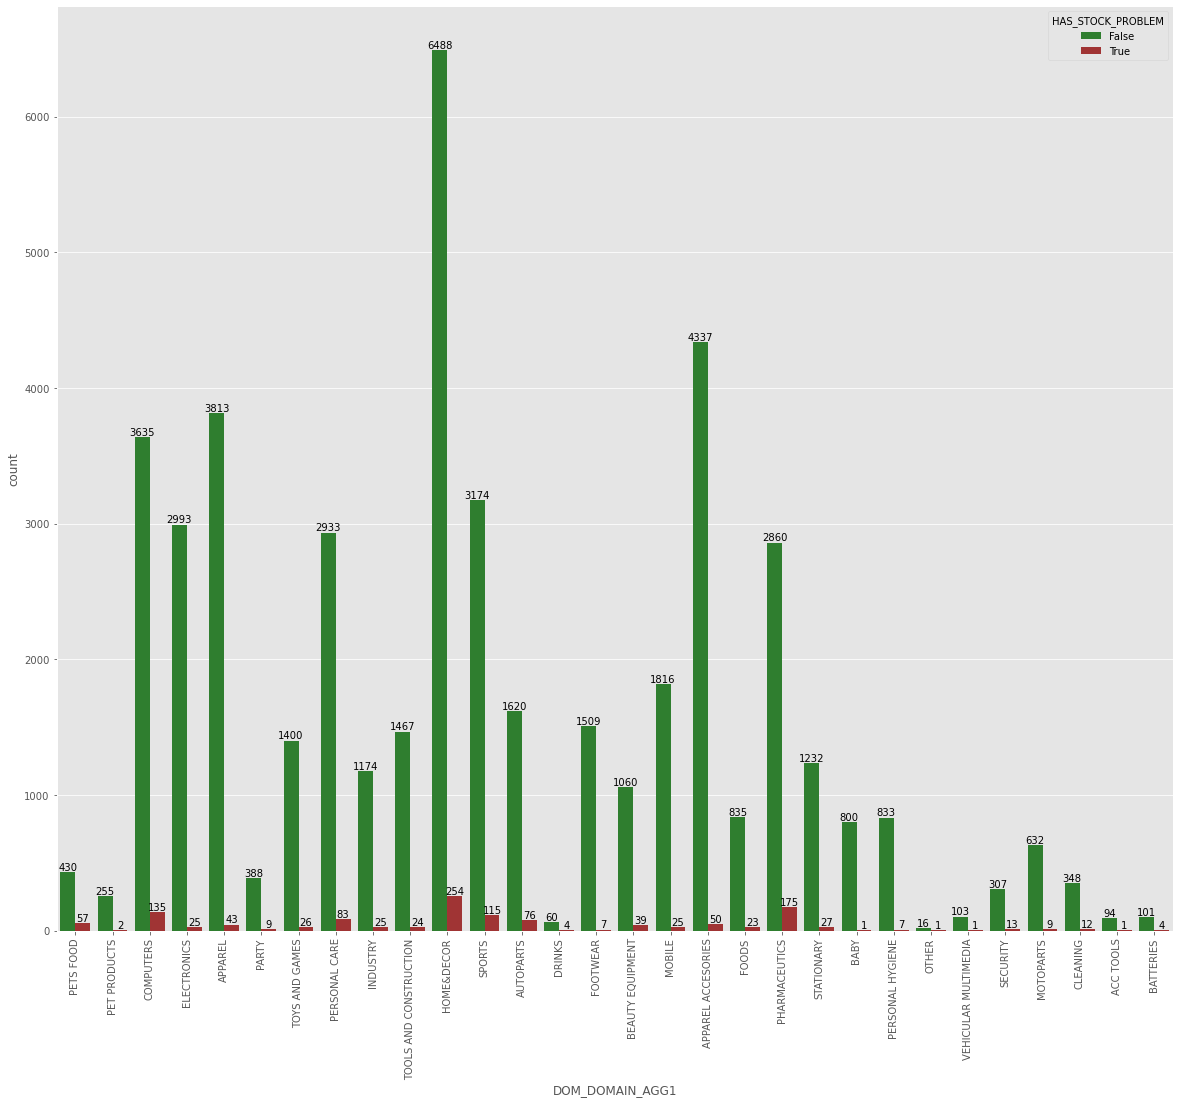

In [10]:
plt.figure(figsize=(20,17))
ax = sns.countplot(data=dep_problem_stock, x='DOM_DOMAIN_AGG1',hue='HAS_STOCK_PROBLEM', palette = ['forestgreen','firebrick'])
for container in ax.containers:
    ax.bar_label(container)

plt.xticks(rotation=90)

In [26]:
count_has_problem_stock = dep_problem_stock[dep_problem_stock['HAS_STOCK_PROBLEM']][['DOM_DOMAIN_AGG1','HAS_STOCK_PROBLEM']].groupby(['DOM_DOMAIN_AGG1']).count().reset_index()

dep_problem_stock_list = count_has_problem_stock[count_has_problem_stock['HAS_STOCK_PROBLEM']>10]['DOM_DOMAIN_AGG1'].unique()
dep_problem_stock = df[df['DOM_DOMAIN_AGG1'].isin(dep_problem_stock_list)].reset_index(drop=True)

Notamos que as ofertas com problemas de disponibilidade têm, em média e/ou mediana, os menores tempos de vigência. Comparando com as ofertas que não apresentaram problema de estoque, em todos os casos, ao menos 75% das ofertas degradaram seus estoques com menores tempos de vigência. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'PETS FOOD'),
  Text(1, 0, 'COMPUTERS'),
  Text(2, 0, 'ELECTRONICS'),
  Text(3, 0, 'APPAREL'),
  Text(4, 0, 'TOYS AND GAMES'),
  Text(5, 0, 'PERSONAL CARE'),
  Text(6, 0, 'INDUSTRY'),
  Text(7, 0, 'TOOLS AND CONSTRUCTION'),
  Text(8, 0, 'HOME&DECOR'),
  Text(9, 0, 'SPORTS'),
  Text(10, 0, 'AUTOPARTS'),
  Text(11, 0, 'BEAUTY EQUIPMENT'),
  Text(12, 0, 'MOBILE'),
  Text(13, 0, 'APPAREL ACCESORIES'),
  Text(14, 0, 'FOODS'),
  Text(15, 0, 'PHARMACEUTICS'),
  Text(16, 0, 'STATIONARY'),
  Text(17, 0, 'SECURITY'),
  Text(18, 0, 'CLEANING')])

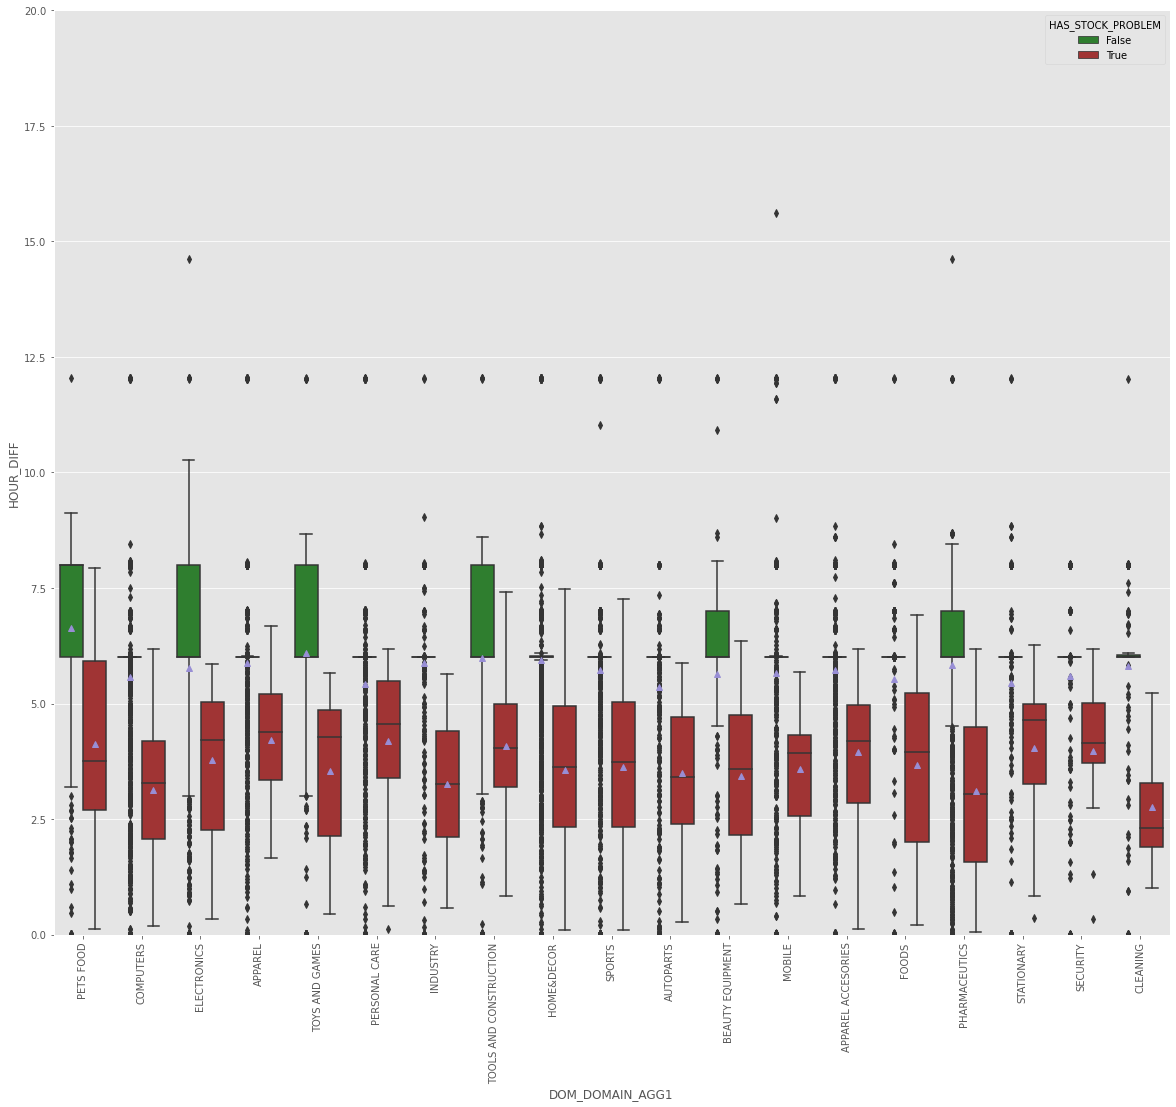

In [27]:
plt.figure(figsize=(20,17))
sns.boxplot(data=dep_problem_stock, x='DOM_DOMAIN_AGG1', y='HOUR_DIFF', hue='HAS_STOCK_PROBLEM', palette = ['forestgreen','firebrick'], showmeans=True)
plt.ylim(0, 20)
plt.xticks(rotation=90)

In [25]:
summary_dep_problem_stock = dep_problem_stock.groupby(dep_problem_stock['DOM_DOMAIN_AGG1']).agg(
    HOUR_DIFF_MEDIAN=('HOUR_DIFF', np.median),
    HOUR_DIFF_MEAN=('HOUR_DIFF', np.mean),
    HOUR_DIFF_SD=('HOUR_DIFF', np.std),  
).reset_index()

summary_dep_problem_stock

,DOM_DOMAIN_AGG1,HOUR_DIFF_MEDIAN,HOUR_DIFF_MEAN,HOUR_DIFF_SD
0,APPAREL,6.000833,5.857092,1.850591
1,APPAREL ACCESORIES,6.000556,5.712666,2.473180
2,AUTOPARTS,6.000278,5.271163,1.937738
3,BEAUTY EQUIPMENT,6.000556,5.564040,2.306541
4,CLEANING,6.000556,5.717057,2.156317
5,COMPUTERS,6.000556,5.485180,2.156788
6,ELECTRONICS,6.000833,5.752640,2.334480
7,FOODS,6.000556,5.488726,2.101464
8,HOME&DECOR,6.000556,5.860528,1.971473
9,INDUSTRY,6.000556,5.824953,1.885191


In [14]:
dep_problem_stock['MEDIAN_LIM'] = [dep_problem_stock['HOUR_DIFF']>np.mean(summary_dep_problem_stock['HOUR_DIFF_MEDIAN'])][0].values
dep_problem_stock['MEAN_LIM'] = [dep_problem_stock['HOUR_DIFF']>np.mean(summary_dep_problem_stock['HOUR_DIFF_MEAN'])][0].values

In [28]:
remaining_stock_negative

,OFFER_START_DATE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,DOM_DOMAIN_AGG1,HOUR_DIFF,HAS_STOCK_PROBLEM,MEDIAN_LIM,MEAN_LIM
0,2021-06-22,4,-2,4.72,6,PETS FOOD,7.045278,1,1,1
1,2021-06-22,10,-1,103.03,11,COMPUTERS,4.094167,1,0,0
2,2021-06-22,10,-1,3.83,11,COMPUTERS,4.092222,1,0,0
3,2021-06-22,5,-4,12.18,9,HOME&DECOR,1.339167,1,0,0
4,2021-06-22,8,-1,12.61,9,PETS FOOD,2.705278,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1222,2021-06-19,10,-2,110.18,12,TOOLS AND CONSTRUCTION,6.529722,1,1,1
1223,2021-06-19,15,-1,29.50,16,HOME&DECOR,5.915278,1,0,1
1224,2021-06-19,5,-1,6.38,6,APPAREL,5.461111,1,0,0
1225,2021-06-19,5,-1,8.77,6,AUTOPARTS,5.602778,1,0,0


Utilizamos a média e a mediana como pontos de corte na detecção de ofertas problemáticas.

O gráfico abaixo nos mostra que, a partir dessas medidas centrais, podemos criar alguma estratégia para um controle mais efetivo do problema. 

Por exemplo, obter _thresholds_ mais robustos, que ponderem tais medidas centrais pelo inverso da frequência de ocorrência de ofertas problemáticas em cada departamento.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'APPAREL'),
  Text(1, 0, 'APPAREL ACCESORIES'),
  Text(2, 0, 'AUTOPARTS'),
  Text(3, 0, 'BEAUTY EQUIPMENT'),
  Text(4, 0, 'CLEANING'),
  Text(5, 0, 'COMPUTERS'),
  Text(6, 0, 'ELECTRONICS'),
  Text(7, 0, 'FOODS'),
  Text(8, 0, 'HOME&DECOR'),
  Text(9, 0, 'INDUSTRY'),
  Text(10, 0, 'MOBILE'),
  Text(11, 0, 'PERSONAL CARE'),
  Text(12, 0, 'PETS FOOD'),
  Text(13, 0, 'PHARMACEUTICS'),
  Text(14, 0, 'SECURITY'),
  Text(15, 0, 'SPORTS'),
  Text(16, 0, 'STATIONARY'),
  Text(17, 0, 'TOOLS AND CONSTRUCTION'),
  Text(18, 0, 'TOYS AND GAMES')])

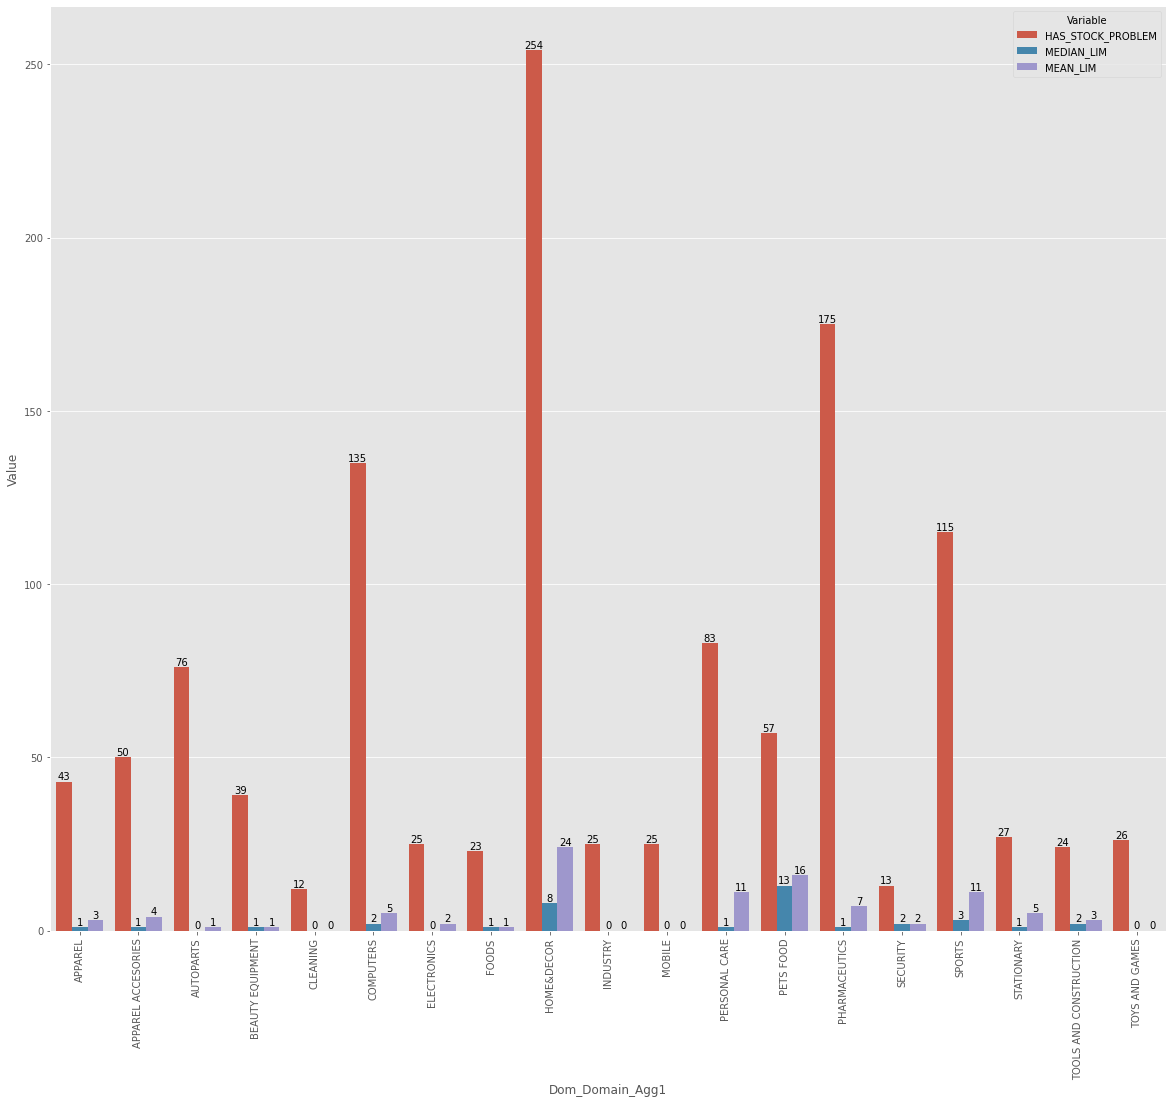

In [15]:
remaining_stock_negative = dep_problem_stock[dep_problem_stock['REMAINING_STOCK_AFTER_END']<0].reset_index(drop=True)
remaining_stock_negative['HAS_STOCK_PROBLEM'] = remaining_stock_negative['HAS_STOCK_PROBLEM']*1
remaining_stock_negative['MEDIAN_LIM'] = remaining_stock_negative['MEDIAN_LIM']*1
remaining_stock_negative['MEAN_LIM'] = remaining_stock_negative['MEAN_LIM']*1


compare_counts = remaining_stock_negative['HAS_STOCK_PROBLEM'].groupby(remaining_stock_negative['DOM_DOMAIN_AGG1']).sum().reset_index()
compare_counts['MEDIAN_LIM'] = remaining_stock_negative['MEDIAN_LIM'].groupby(remaining_stock_negative['DOM_DOMAIN_AGG1']).sum().values
compare_counts['MEAN_LIM'] = remaining_stock_negative['MEAN_LIM'].groupby(remaining_stock_negative['DOM_DOMAIN_AGG1']).sum().values

plt.figure(figsize=(20,17))
ax = sns.barplot(x='Dom_Domain_Agg1', y='Value', hue='Variable', data=compare_counts.melt(id_vars='DOM_DOMAIN_AGG1').rename(columns=str.title))
for container in ax.containers:
    ax.bar_label(container)

plt.xticks(rotation=90)

Uma outra variável que pode ser levada em consideração a este _threshold_ é o GMV das ofertas problemáticas. Uma vez que podemos ser mais flexíveis, assumindo mais riscos, em departamentos que nos retornam um maior GMV ou _ticket_ médio, **dentro do contexto** (por exemplo, produtos de beleza e farmaceuticos).

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'PETS FOOD'),
  Text(1, 0, 'COMPUTERS'),
  Text(2, 0, 'HOME&DECOR'),
  Text(3, 0, 'FOODS'),
  Text(4, 0, 'INDUSTRY'),
  Text(5, 0, 'PERSONAL CARE'),
  Text(6, 0, 'PHARMACEUTICS'),
  Text(7, 0, 'BEAUTY EQUIPMENT'),
  Text(8, 0, 'SPORTS'),
  Text(9, 0, 'AUTOPARTS'),
  Text(10, 0, 'APPAREL'),
  Text(11, 0, 'ELECTRONICS'),
  Text(12, 0, 'TOYS AND GAMES'),
  Text(13, 0, 'STATIONARY'),
  Text(14, 0, 'APPAREL ACCESORIES'),
  Text(15, 0, 'TOOLS AND CONSTRUCTION'),
  Text(16, 0, 'MOBILE'),
  Text(17, 0, 'SECURITY'),
  Text(18, 0, 'CLEANING')])

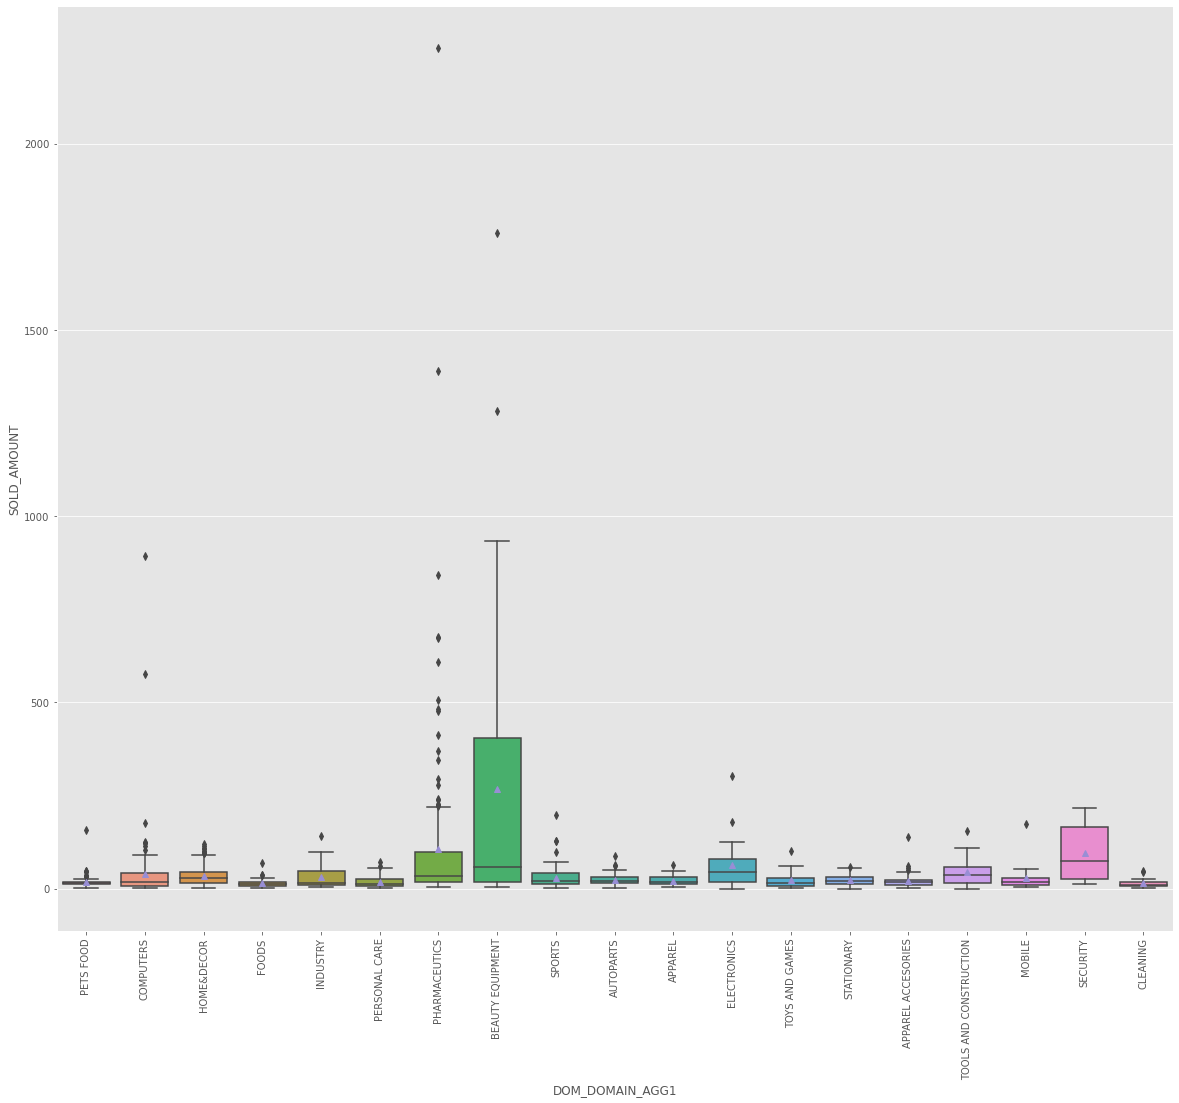

In [20]:
plt.figure(figsize=(20,17))
sns.boxplot(data=remaining_stock_negative, x='DOM_DOMAIN_AGG1', y='SOLD_AMOUNT', showmeans=True)
plt.xticks(rotation=90)